####  🍁Check Versions

In [1]:
# !python --version

import cupy as cp
cp.__version__

# !pip show jedi
# !pip show setuptools
# !pip show pip

'13.3.0'

#### 🍁 Set folder

In [2]:
import os

models_dir = "/kaggle/working/models/"  # Kaggle's default working directory

# Ensure the directory exists
os.makedirs(models_dir, exist_ok=True)

### Preprocessing

In [3]:
#1 Import
from keras.datasets import mnist
(x_train, y_train), (_, _) = mnist.load_data()
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

#2 Flatten
x_train = x_train.reshape(x_train.shape[0], -1)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

#3 Subsets
subset_size = 1000
x_train_subset = x_train[:subset_size]
y_train_subset = y_train[:subset_size]
print(f"x_train_subset shape: {x_train_subset.shape}")

#4 PCA
from sklearn.decomposition import PCA
import pickle
n_components = 77
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_subset)
print(f"x_train_pca shape: ", x_train_pca.shape)
# Load PCA instance
with open("models/pca_model.pkl", "wb") as file:
    pickle.dump(pca, file)  # Save the fitted PCA model

#5 Normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_norm = scaler.fit_transform(x_train_pca)
print(f"x_train_norm shape: {x_train_norm.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28), y_train shape: (60000,)
x_train shape: (60000, 784), y_train shape: (60000,)
x_train_subset shape: (1000, 784)
x_train_pca shape:  (1000, 77)
x_train_norm shape: (1000, 77)


### Step 1: Import Data

In [ ]:
# from sklearn.datasets import fetch_openml
# import numpy as np

# # Import MNIST dataset
# mnist = fetch_openml('mnist_784', version=1)
# x_full = mnist.data.values  # Full dataset
# y_full = mnist.target.values.astype(int)  # Labels (0–9)

# print(f"x_full shape: {x_full.shape}, y_full shape: {y_full.shape}")

### Step 2: Create Subset

In [ ]:
# # Create a subset of training data (1000 images per digit)
# subset_size = 100
# x_subset = []
# y_subset = []

# for digit in range(10):
#     digit_indices = np.where(y_full == digit)[0][:subset_size]
#     x_subset.append(x_full[digit_indices])
#     y_subset.append(y_full[digit_indices])

# x_subset = np.vstack(x_subset)
# y_subset = np.hstack(y_subset)

# print(f"x_subset shape: {x_subset.shape}, y_subset shape: {y_subset.shape}")
# print(f"Unique labels in y_subset: {np.unique(y_subset)}")
# print(f"x_subset[3].shape: {x_subset[3].shape}")

### Step 3: Apply PCA

In [ ]:
# from sklearn.decomposition import PCA
# import pickle

# # Apply PCA to reduce dimensionality
# n_components = 77
# pca = PCA(n_components=n_components)
# x_pca = pca.fit_transform(x_subset)

# # Load PCA instance
# with open("models/pca_model.pkl", "wb") as file:
#     pickle.dump(pca, file)  # Save the fitted PCA model

# print(f"Original shape: {x_subset.shape}, PCA shape: {x_pca.shape}")
# print(f"variance retained: {np.sum(pca.explained_variance_ratio_)*100}%")

# print(f"shape of x_pca: ", x_pca.shape)
# print(f"shape of x_pca[5]: ", x_pca[5].shape)

# print(f"check any image vector: ", x_pca[5])

### Step 4: Thresholding

In [ ]:
# # Thresholding: Convert to binary
# threshold_value = 0
# x_b = (x_pca > threshold_value).astype(int)

# print(f"x_b shape: {x_b.shape}")
# print(f"x_b[5] =", x_b[5])

# print(f"x_b =", x_b)

### Step 4: Normalizing

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# # Normalize PCA-transformed data
# scaler = MinMaxScaler(feature_range=(0, 1))
# x_b = scaler.fit_transform(x_pca)

# print(f"x_b.shape =", x_b.shape)

### Step 5: Dataset Shuffle

In [ ]:
# # Shuffle the dataset
# shuffle_indices = np.arange(len(y_subset))
# np.random.shuffle(shuffle_indices)

# x_b = x_b[shuffle_indices]
# y_subset = y_subset[shuffle_indices]

# print(f"x_b.shape =", x_b.shape)
# print(f"y_subset.shape =", y_subset.shape)

# print(f"x_b =", x_b)
# print(f"y_subset =", y_subset)

### Step 6: Train Classifiers

In [5]:
import pickle
import cupy as cp
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Feasibility check function
def check_feasibility_and_compute_coefficients(z, x_train_norm, y_binary):
    num_data_points = x_train_norm.shape[0]
    num_coefficients = n_components + 1  # (+1 for the first constant terms α0 & β0)
    delta = 1e-6  # a small positive value

    # Construct G(x) and H(x) matrices for numerator and denominator
    G = cp.zeros((num_data_points, num_coefficients))  # Numerator matrix
    H = cp.zeros((num_data_points, num_coefficients))  # Denominator matrix

    for i in range(num_data_points):
      G[i, 0] = 1
      H[i, 0] = 1
      for j in range(num_coefficients-1):
        G[i, j+1] = x_train_norm[i, j] ** (j+1)
        H[i, j+1] = x_train_norm[i, j] ** (j+1)

    # print(f"G: {G}")
    # print(f"G.shape =", G.shape)
    # print(f"H: {H}")

    # Construct constraints for Ax <= b
    A = []
    b = []

    for i in range(num_data_points):
        f_plus_z = y_binary[i] + z  # Upper bound
        f_minus_z = y_binary[i] - z  # Lower bound

        # Constraint 1: (f(xi) - z) * β^T H(xi) - α^T G(xi) ≤ θ
        # (-G(xi))αT + (f(xi) - z).H(xi)βT + (-1)θ ≤ 0
        constraint_1 = cp.zeros(2 * num_coefficients + 1)
        # (1) Coefficients of α
        constraint_1[0:num_coefficients] = -G[i]
        # (2) Coefficients of β
        constraint_1[num_coefficients:2 * num_coefficients] = (f_minus_z) * H[i]
        # (3) Coefficient of θ (last element)
        constraint_1[-1] = -1
        A.append(constraint_1)
        b.append(0)

        # Constraint 2: α^T G(xi) + (-1).(f(xi) + z) * β^T H(xi) ≤ θ
        # G(xi).αT + (-1)(f(xi) - z).H(xi)βT + (-1)θ ≤ 0
        constraint_2 = cp.zeros(2 * num_coefficients + 1)
        # (1) Coefficients of α
        constraint_2[0:num_coefficients] = G[i]
        # (2) Coefficients of β
        constraint_2[num_coefficients:2 * num_coefficients] = -(f_plus_z) * H[i]
        # (3) Coefficient of θ (last element)
        constraint_2[-1] = -1
        A.append(constraint_2)
        b.append(0)

        # Constraint 3: β^T H(x) ≥ δ
        # (0)α^T + (-H(x)) β^T + (0)θ ≤ -δ
        constraint_3 = cp.zeros(2 * num_coefficients + 1)
        # Coefficient of β
        constraint_3[num_coefficients:2 * num_coefficients] = -H[i]
        A.append(constraint_3)
        b.append(-delta)

    # Convert CuPy arrays to NumPy arrays for SciPy
    A = cp.asnumpy(cp.array(A))
    b = cp.asnumpy(cp.array(b))

    # print(f"A =", len(A))
    # print(f"A: {A[0]}")
    # print(f"A.shape =", A.shape)
    # print(f"len(A[0]): {len(A[0])}")
    # print(f"len(b): {len(b)}")
    # print(f"n_components =", n_components)

    # Objective function to minimize θ
    c = cp.asnumpy(cp.zeros(2 * num_coefficients + 1))
    c[-1] = 1  # Only θ has a coefficient in the objective function

    # Solve the linear programming problem (methods: highs, revised simplex)
    result = linprog(c, A_ub=A, b_ub=b, method="highs")

    # Check feasibility and return results
    if result.success:
        alpha_coefficients = result.x[:num_coefficients]
        beta_coefficients = result.x[num_coefficients:2 * num_coefficients]
        theta = result.x[-1]
        return True, alpha_coefficients, beta_coefficients, theta
    else:
        return False, None, None, None


# Bisection loop
def bisection_loop(x_train_norm, y_binary, uL, uH, precision):
    optimal_alpha, optimal_beta, optimal_theta = None, None, None
    z_values = []

    while uH - uL > precision:
        z = (uL + uH) / 2
        z_values.append(z)
        feasible, alpha_coefficients, beta_coefficients, theta = check_feasibility_and_compute_coefficients(z, x_train_norm, y_binary)

        if feasible:
            uH = z
            optimal_alpha, optimal_beta, optimal_theta = alpha_coefficients, beta_coefficients, theta
        else:
            uL = z

    return uH, optimal_alpha, optimal_beta, optimal_theta, z_values

# Train a classifier for each digit
for digit in range(10):
    print(f"Training classifier for digit {digit}...")

    # Assign labels: Positive for the current digit, negative for others
    # y_binary = (y_train_subset == digit).astype(int)
    y_binary = (y_train_subset == digit).astype(float)

    # Scale binary labels to larger values
    # Positive class = 2, Negative class = 4
    y_binary = np.where(y_binary == 1, 2, 4)

    # print(f"y_binary =", y_binary)
    # print(f"y_train_subset =", y_train_subset)

    # Bisection parameters
    uL = 0  # Initial lower bound
    uH = 500  # Initial upper bound
    precision = 1e-6 # Precision threshold

    # Run bisection loop
    optimal_z, optimal_alpha, optimal_beta, optimal_theta, z_values = bisection_loop(x_train_norm, y_binary, uL, uH, precision)

    # Print results
    print(f"Number of Iterations: {len(z_values)}")
    # print(f"z Values in all Iterations: {z_values}")
    print(f"Optimal z (Maximum Deviation): {optimal_z}")

    # # Plot convergence of z values
    # plt.figure(figsize=(8, 6))
    # plt.plot(range(len(z_values)), z_values, marker='o', linestyle='-')
    # plt.xlabel("Iteration")
    # plt.ylabel("z Value")
    # plt.title("Convergence of z Values")
    # plt.grid(True)
    # plt.show()

    print(f"Optimized Coefficients (Numerator α): {optimal_alpha}")
    print(f"Optimized Coefficients (Denominator β): {optimal_beta}")
    print(f"Optimal θ: {optimal_theta}")
    
    # print(f"rational_function =", rational_function(x_train_norm[0], optimal_alpha, optimal_beta))

    # Save the model
    model = {
        "alpha": optimal_alpha,
        "beta": optimal_beta,
        "theta": optimal_theta,
        "n_components": n_components
    }

    with open(f"{models_dir}classifier_{digit}.pkl", "wb") as file:
        pickle.dump(model, file)

    print(f"Model for digit {digit} saved at {models_dir}")

Training classifier for digit 0...
Number of Iterations: 29
Optimal z (Maximum Deviation): 9.313225746154785e-07
Optimized Coefficients (Numerator α): [ 2.99997123e-06  0.00000000e+00  2.86961614e-11  1.43943562e-11
  1.84189951e-10  1.02687708e-10  8.87661018e-11  1.11352991e-10
 -2.05692198e-11 -2.16439161e-09  1.61271358e-10  9.29465554e-10
  6.74584705e-09  4.70383719e-09  1.09576575e-08 -3.20804981e-09
  1.06254823e-08 -1.25503142e-08 -2.32104980e-08 -8.22661028e-08
 -1.40174297e-08  0.00000000e+00 -8.80806916e-10  4.19446640e-09
 -3.60808480e-09  0.00000000e+00  8.44786043e-09  5.30845059e-10
  3.36706559e-06 -5.89288076e-09  0.00000000e+00  1.17713960e-09
  5.88848959e-07 -2.57389394e-09 -1.51300287e-10 -1.49444685e-08
 -2.05245340e-08  3.45962582e-08  0.00000000e+00  0.00000000e+00
  2.45404912e-09 -1.46727459e-10  0.00000000e+00  1.01323259e-08
  1.99247879e-06 -1.46501700e-09  2.26890883e-08 -4.32547615e-11
 -3.46822779e-08 -3.35404904e-10  4.48647392e-11  0.00000000e+00
 -6.

### [Testing]

x_test shape: (10000, 28, 28), y_test shape: (10000,)
x_test shape: (10000, 784), y_test shape: (10000,)
x_test_subset shape: (10000, 784)
x_test_pca shape:  (10000, 77)
x_test_norm shape: (10000, 77)
Accuracy for digit 0: 66.60%
Accuracy for digit 1: 87.41%
Accuracy for digit 2: 60.00%
Accuracy for digit 3: 39.41%
Accuracy for digit 4: 58.39%
Accuracy for digit 5: 51.05%
Accuracy for digit 6: 40.56%
Accuracy for digit 7: 48.02%
Accuracy for digit 8: 50.97%
Accuracy for digit 9: 61.94%
Overall Accuracy: 56.44%


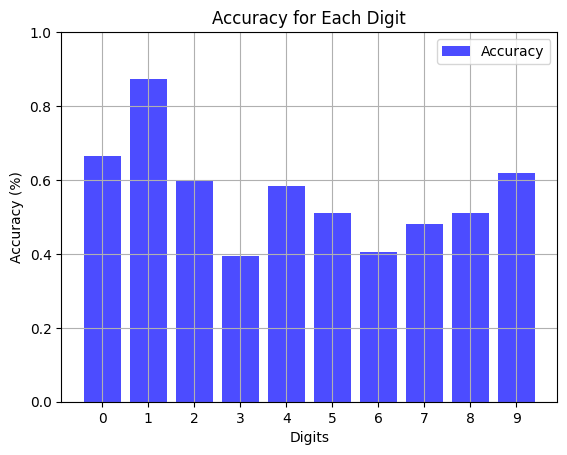

In [14]:
import cupy as cp
import numpy as np
from sklearn.decomposition import PCA
import pickle
import matplotlib.pyplot as plt

#------------------------------------------
# Define the rational function
def rational_function(x, alpha, beta):
    """
    r(x) = (α_0 + α_1*x1**1 + α_2*x2**2 + ...) / 
           (β_0 + β_1*x1**1 + β_2*x2**2 + ...).
    """
    numerator = alpha[0] + sum(alpha[i+1] * x[i] ** (i + 1) for i in range(len(x)))
    denominator = beta[0] + sum(beta[i+1] * x[i] ** (i + 1) for i in range(len(x)))
    return numerator / denominator

# #------------------------------------------
# #1 Load MNIST test data (10,000 images)
# from keras.datasets import mnist
# (_, _), (x_test, y_test) = mnist.load_data()
# print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# #------------------------------------------
# #2 Subset the test dataset
# subset_size = 10000
# x_test_subset = x_test[:subset_size]
# y_test_subset = y_test[:subset_size]
# print(f"Shape of test subset: {x_test_subset.shape}")

# #------------------------------------------
# # Flatten the test dataset (convert from 28x28 to 784)
# x_test_subset = x_test_subset.reshape(x_test_subset.shape[0], -1)
# print(f"Shape of flattened test subset: {x_test_subset.shape}")

# #------------------------------------------
# #3 Load PCA instance
# with open("models/pca_model.pkl", "rb") as file:
#     pca = pickle.load(file)  # Load the PCA model trained on training data
    
# x_test_pca = pca.transform(x_test_subset)  # Transform test data using the saved PCA

# print(f"Shape of PCA-transformed test subset: {x_test_pca.shape}")

# #------------------------------------------
# # #4 Thresholding: Convert PCA-transformed data to binary (0s and 1s)
# # threshold_value = 0
# # x_test_binary = (x_test_pca > threshold_value).astype(int)
# # print(f"Binary thresholded test subset: {x_test_binary.shape}")

# #------------------------------------------
# #4 Normalize PCA-transformed data
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(0, 1))
# x_test_norm = scaler.fit_transform(x_test_pca)

# #------------------------------------------
# #5 Shuffle the dataset
# shuffle_indices = np.arange(len(y_test_subset))
# np.random.shuffle(shuffle_indices)

# x_test_shuf = x_test_norm[shuffle_indices]
# y_test_subset = y_test_subset[shuffle_indices]

#------x-x-x--------
#------x-x-x--------
# Import
from keras.datasets import mnist
(_, _), (x_test, y_test) = mnist.load_data()
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

#1 Flatten
x_test = x_test.reshape(x_test.shape[0], -1)
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

#2 Subsets
subset_size = 10000
x_test_subset = x_test[:subset_size]
y_test_subset = y_test[:subset_size]
print(f"x_test_subset shape: {x_test_subset.shape}")

#3 PCA
from sklearn.decomposition import PCA
import pickle
n_components = 77
pca = PCA(n_components=n_components)
x_test_pca = pca.fit_transform(x_test_subset)
print(f"x_test_pca shape: ", x_test_pca.shape)

# # with training settings
# with open("models/pca_model.pkl", "rb") as file:
#     pca = pickle.load(file)  # Load the PCA model trained on training data
    
# # Transform test data using the saved PCA
# x_test_pca = pca.transform(x_test_subset)

#4 Normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
x_test_norm = scaler.fit_transform(x_test_pca)
print(f"x_test_norm shape: {x_test_norm.shape}")

#------------------------------------------
# Load the saved models and test
models_dir = "/kaggle/working/models/"  # Update based on your environment
accuracies = []

#------------------------------------------
for digit in range(10):
    # Load model for each digit
    with open(f"{models_dir}classifier_{digit}.pkl", "rb") as file:
        model = pickle.load(file)

    alpha = model["alpha"]
    beta = model["beta"]
    theta = model["theta"]

    # Evaluate the rational function for each test data point
    y_predicted = [
        rational_function(x, alpha, beta) for x in x_test_norm
    ]

    # Convert predictions to binary (1 for this digit, 0 for others)
    y_pred_binary = np.array(y_predicted) < 3
    y_true_binary = y_test_subset == digit

    # Calculate accuracy for this digit
    accuracy = np.mean(y_pred_binary == y_true_binary)
    accuracies.append(accuracy)

    print(f"Accuracy for digit {digit}: {accuracy*100:.2f}%")

#------------------------------------------
# Calculate and print overall accuracy
overall_accuracy = np.mean(accuracies)
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")

#------------------------------------------
# Plotting accuracies for each digit
plt.bar(range(10), accuracies, color='blue', alpha=0.7, label="Accuracy")
plt.xlabel("Digits")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy for Each Digit")
plt.xticks(range(10))
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

# print(f"y_pred_binary =", y_pred_binary)
# print(f"y_true_binary =", y_true_binary)

# print(f"y_pred_binary.shape =", y_pred_binary.shape)
# print(f"y_true_binary.shape =", y_true_binary.shape)

x_test shape: (10000, 28, 28), y_test shape: (10000,)


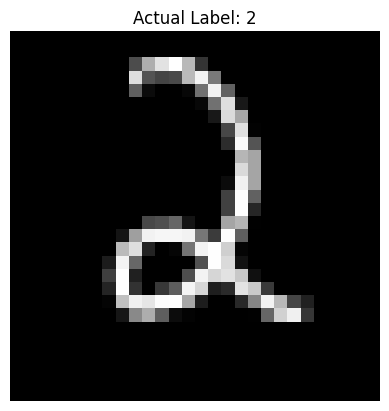

Rational Function Outputs for Each Digit:
Digit 0: 3.0000
Digit 1: 2.9998
Digit 2: 3.0004
Digit 3: 3.0000
Digit 4: 3.0000
Digit 5: 3.0000
Digit 6: 3.0000
Digit 7: 3.0000
Digit 8: 3.0000
Digit 9: 2.9999

Predicted Digit: 1
Actual Label: 2
Prediction: Incorrect ❌


In [23]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Define the rational function
def rational_function(x, alpha, beta):
    """
    r(x) = (α_0 + α_1*x1**1 + α_2*x2**2 + ...) / 
           (β_0 + β_1*x1**1 + β_2*x2**2 + ...).
    """
    numerator = alpha[0] + sum(alpha[i+1] * x[i] ** (i + 1) for i in range(len(x)))
    denominator = beta[0] + sum(beta[i+1] * x[i] ** (i + 1) for i in range(len(x)))
    return numerator / denominator

# Function to cross-check a single test image
def cross_check_single_image(x_test_subset, y_test_subset, index, models_dir, pca_model_path):
    """
    Cross-check a single image from the test dataset.
    
    Steps:
    - Displays the actual test image at the given index.
    - Shows the actual label.
    - Calculates rational function outputs for all digit models.
    - Predicts the digit with the highest confidence.
    """
    # Load the PCA model
    with open(pca_model_path, "rb") as file:
        pca = pickle.load(file)
    
    # Preprocess the test image
    selected_image = x_test_subset[index]  # Select the test image
    selected_label = y_test_subset[index]  # Select the actual label
    
    # Flatten and apply PCA transformation
    selected_image_flat = selected_image.reshape(1, -1)  # Flatten (1, 784)
    selected_image_pca = pca.transform(selected_image_flat)  # Apply PCA
    
    # Normalize using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    selected_image_normalized = scaler.fit_transform(selected_image_pca)[0]  # Normalized PCA data
    
    # Display the actual image
    plt.imshow(selected_image, cmap="gray")
    plt.title(f"Actual Label: {selected_label}")
    plt.axis("off")
    plt.show()
    
    # Load all digit models and calculate rational function outputs
    rational_outputs = {}
    for digit in range(10):
        # Load the respective model
        with open(f"{models_dir}classifier_{digit}.pkl", "rb") as file:
            model = pickle.load(file)
        
        alpha = model["alpha"]
        beta = model["beta"]
        
        # Calculate the rational function output
        output = rational_function(selected_image_normalized, alpha, beta)
        rational_outputs[digit] = output
    
    # Print rational function outputs
    print("Rational Function Outputs for Each Digit:")
    for digit, output in rational_outputs.items():
        print(f"Digit {digit}: {output:.4f}")
    
    # Predict the digit based on the closest output to the positive class (e.g., 2)
    predictions = {digit: abs(output - 2) for digit, output in rational_outputs.items()}
    predicted_digit = min(predictions, key=predictions.get)
    
    print(f"\nPredicted Digit: {predicted_digit}")
    print(f"Actual Label: {selected_label}")
    
    # Final Cross-Check
    if predicted_digit == selected_label:
        print("Prediction: Correct ✅")
    else:
        print("Prediction: Incorrect ❌")

# Main execution
if __name__ == "__main__":
    # Load the MNIST test dataset
    from keras.datasets import mnist
    (_, _), (x_test, y_test) = mnist.load_data()
    print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
    
    # Set up test dataset
    subset_size = 10000  # Use all test images
    x_test_subset = x_test[:subset_size]
    y_test_subset = y_test[:subset_size]
    
    # Path to saved models and PCA
    models_dir = "/kaggle/working/models/"  # Update the directory path
    pca_model_path = "models/pca_model.pkl"
    
    # Select an index (change this to test different images)
    test_index = 47 # Set the index of the image you want to test
    
    # Cross-check the selected image
    cross_check_single_image(x_test_subset, y_test_subset, test_index, models_dir, pca_model_path)
